# [ADA-2020]: P4-milestone
### Group project: Friendship and home position

**Objective**: Inspect the difference in quantity, quality and distribution of friends according to where a person lives

**Authors**: ADA Dream Team

**Study paper**: Eunjoon Cho, Seth A. Myers and Jure Leskovec, *Friendship and Mobility: User Movement in Location-Based Social Network*, Standford University, 2011

**Datasets**:
1. Gowalla dataset: https://snap.stanford.edu/data/loc-gowalla.html. A dataset from the paper. Checkins of users and friends relationship.
2. Brightkite dataset: https://snap.stanford.edu/data/loc-Brightkite.html. A dataset from the paper. Checkins of users and friends relationship.
3. Compilation of UNData: https://www.kaggle.com/sudalairajkumar/undata-country-profiles. Different characteristics for each country.
4. Compilation of USGovt: https://www.kaggle.com/fernandol/countries-of-the-world. More characteristics for each country.
5. happiness2020.pkl and countries_info.csv from "tutorial 01- Handling data", extracted from the World Happiness Report of the United Nations Sustainable Development Solution Network. More characteristics for each country.

**Method**: The method that will be used here is the following:

<span style="color:red">!! ADD WHOLE METHOD (SUMMARY)!!</span>

**Others**: 
The abstract as well as the research questions can be found on the README.md.

In [1]:
#Librairies

#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Convert country names to ISO codes
import pycountry 
import pycountry_convert 

#Convert longitudes and latitudes to country
import reverse_geocoder 

#Plot country map
import cartopy 
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon

In [2]:
#Global constants
PATH = "data/"

## 0. Extraction of the data, preprocessing and merge
In this section, the different dataset will be loaded and preprocessed. Preprocess is the same as the one presented in the tutorial and in our previous milestone. The countries dataset will be merged together to form a big dataset with all the data about each country.

### 0.1 Users dataset
Gowalla and Brightkite are social networks. Their dataset are composed of checkins of each users (place, date, ...) and their friendship relations.

In [3]:
#Extraction parameters
EXTENSION = ".txt.gz"
SEPARATOR = "\t"
CHECKIN_COLUMNS_NAME = ["user", "check-in time", "latitude", "longitude", "location id"]
EDGE_COLUMNS_NAME = ["friend1", "friend2"]
#Extract dataframe from .txt.gz (tabulated separated without header)
bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)

#Remove from checkin some invalid points (null data and incoherent latitudes)
bright_0_lat = bright_checkins[bright_checkins["latitude"] == 0]
bright_0_lat_long = bright_0_lat[bright_0_lat["longitude"] == 0]
bright_checkins = bright_checkins.drop(bright_0_lat_long.index)
bright_big_lat = bright_checkins[bright_checkins["latitude"]>90]
bright_checkins = bright_checkins.drop(bright_big_lat.index)
bright_small_lat = bright_checkins[bright_checkins["latitude"]<-90]
bright_checkins = bright_checkins.drop(bright_small_lat.index)

gowalla_0_lat = gowalla_checkins[gowalla_checkins["latitude"] == 0]
gowalla_0_lat_long = gowalla_0_lat[gowalla_0_lat["longitude"] == 0]
gowalla_checkins = gowalla_checkins.drop(gowalla_0_lat_long.index)
gowalla_big_lat = gowalla_checkins[gowalla_checkins["latitude"]>90]
gowalla_checkins = gowalla_checkins.drop(gowalla_big_lat.index)
gowalla_small_lat = gowalla_checkins[gowalla_checkins["latitude"]<-90]
gowalla_checkins = gowalla_checkins.drop(bright_small_lat.index)

#Sample dataframe to analyze and verify structure
#bright_edges.sample(10)
bright_checkins.sample(10)
#gowalla_edges.sample(10)
#gowalla_checkins.sample(10)

,user,check-in time,latitude,longitude,location id
2600960,10718,2010-07-31T06:08:25Z,35.655432,139.660933,b12cb6ac11bc73c430163aacae33fdf0
3227646,14165,2008-06-20T15:16:37Z,37.790806,-122.390128,bb6064d35d0ad4cd5aea63d77b9f80acea5493d3
1142480,3167,2008-07-22T17:59:06Z,34.451456,-119.759822,58490b6132be57215b64c92753778969ff821cfe
4305312,36012,2010-07-11T06:58:51Z,39.602388,-119.802141,fd614e0b9d947410038c37a2777341ee
3818173,24084,2009-02-01T15:40:40Z,51.350638,6.338511,4bf65e30f06e11dd921b003048c0801e
2284848,9108,2008-07-21T05:16:50Z,45.563058,-122.624466,d4e206bb3d91aa8cb762891296b3784ee4ed573f
632425,1880,2009-07-14T07:46:25Z,35.500000,139.500000,b9d6da9ea22411dda906a7291e662bb1
4113991,30395,2009-01-30T15:01:40Z,40.793395,-77.860001,ee2cfba2a22411dda5766f14e65d9a37
1567109,6588,2009-09-11T19:08:56Z,34.154910,-118.645300,fb51b21a339111de891a003048c0801e
3009695,13157,2010-10-12T06:22:44Z,45.514300,-73.573681,5c2bc9ba3d2211deb9db003048c10834


### 0.2 Countries dataset
Three different dataset with informations about countries will be used. The first one is from the World Happiness Report of the United Nations Sustainable Development Solution Network, it was presented in the Tutorial of this class; it will be refered as country_WHR (for World Happiness Report). The second one is a compilation (from https://www.kaggle.com/sudalairajkumar/undata-country-profiles) of data from the UN (http://data.un.org/); it will refered as country_UN. The last one is also a compilation (https://www.kaggle.com/fernandol/countries-of-the-world) of data from the CIA (https://www.cia.gov/library/publications/the-world-factbook/); it will be refered as country_CIA.

First, we load and preprocess each one. Then we merge all their information into a big dataset; countries_features.

#### 0.2.1  World Happiness Report (WHR)

In [4]:
#Load data
countries = pd.read_csv(PATH+"countries_info.csv")
happiness = pd.read_pickle(PATH+"happiness2020.pkl")

#Lower case countries from happiness so merge will be possible
happiness["country"] = happiness["country"].str.lower()
#Change column name so they will merge (not duplicated) #!may exist a simpler alternative in the merge options
names = countries.columns.tolist()
names[names.index("country_name")] = "country"
countries.columns = names
#Merge
country_WHR = pd.merge(happiness, countries, left_on = "country", right_on = "country")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_WHR = country_WHR.dropna(axis = 1)

#Restore first letter as upper case for latter use
country_WHR.country = country_WHR.country.str.title()

#Sample dataframe to analyze and verify structure
country_WHR.sample(4)

,country,happiness_score,social_support,healthy_life_expectancy,freedom_of_choices,generosity,perception_of_corruption,world_region,area,population
3,Argentina,5.9747,0.900568,68.803802,0.831132,-0.194914,0.842010,Latin America and Caribbean,2766890,39921833
74,Madagascar,4.1656,0.668196,59.105427,0.557574,-0.011824,0.817486,Sub-Saharan Africa,587040,18595469
121,Turkey,5.1318,0.826314,66.902817,0.608830,-0.171046,0.748197,Middle East and North Africa,780580,70413958
15,Brazil,6.3756,0.896724,66.480164,0.799805,-0.101812,0.770601,Latin America and Caribbean,8511965,188078227


#### 0.2.2  United Nation Compilation (UN)

In [5]:
#Load data
country_UN = pd.read_csv(PATH+"country_profile_variables.csv")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_UN = country_UN.dropna(axis = 1)

#Remove Guadeloupe and Mayotte that are french
country_UN = country_UN[country_UN.country != "Guadeloupe"]
country_UN = country_UN[country_UN.country != "Mayotte"]

#Sample dataframe to analyze and verify structure
country_UN.sample(4)

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
42,Chile,SouthAmerica,756102,18055,24.3,98.2,240796,2.3,13416.2,3.9,...,64.3,197,23.4,82.6/4.7,540,85,99.7/93.3,100.0/90.9,0.02,-99
117,Liechtenstein,WesternEurope,160,38,237.0,98.4,6361,1.4,169491.8,0.7,...,96.6,6,43.1,~0.0/1.1,1,74,-99,-99,-99,-99
219,Uruguay,SouthAmerica,173626,3457,19.8,93.5,53442,1.0,15573.8,6.8,...,64.6,106,10.4,6.7/2.0,113,58,100.0/93.9,96.6/92.6,0.04,-99
134,Mongolia,EasternAsia,1564116,3076,2.0,97.9,11758,2.3,3973.4,14.8,...,21.4,41,8.1,20.8/7.2,677,84,66.4/59.2,66.4/42.6,2.21,-99


#### 0.2.3  Central Intelligence Agency Compilation (CIA)

In [6]:
#Load data
country_CIA = pd.read_csv(PATH+"countries of the world.csv")

#Same country index name
country_CIA = country_CIA.rename(columns = {"Country":"country"})

#Remove Guadeloupe and Mayotte that are french and Virgin Islands that are american
country_CIA = country_CIA[country_CIA.country != "Guadeloupe "]
country_CIA = country_CIA[country_CIA.country != "Mayotte "]
country_CIA = country_CIA[country_CIA.country != "Virgin Islands "]

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_CIA = country_CIA.dropna(axis = 1)

#Sample dataframe to analyze and verify structure
country_CIA.sample(4)

,country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio)
25,Bosnia & Herzegovina,EASTERN EUROPE,4498976,51129,"88,0","0,04"
106,Kazakhstan,C.W. OF IND. STATES,15233244,2717300,"5,6","0,00"
86,Guinea,SUB-SAHARAN AFRICA,9690222,245857,"39,4","0,13"
186,Slovenia,EASTERN EUROPE,2010347,20273,"99,2","0,23"


#### 0.2.4 Merge the three datasets
The three datasets will be merged in this section. To be able to merge them we need a common identifier, to do so we use the pycountry library. We did not found a library able to work with pandas so we have to do a lambda iteration, which is reasonable as the number of countries is not incredeibly large and we only do it once. 

Note that the WHR dataset is smaller than the two others. Also note that during this conversion some countries are not correctly identified and so are removed, however these countries are in most cases small islands or countries in development which may have very little nor no data for the networks dataset.

In [7]:
#from https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry
# convert country name in alpha 3 name
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

In [8]:
#Change country names to alpha3 so they can be compared (takes ~ 1 minute)
country_WHR['alpha3_name'] = country_WHR.country.apply(lambda name: do_fuzzy_search(name))
country_UN['alpha3_name'] = country_UN.country.apply(lambda name: do_fuzzy_search(name))
country_CIA['alpha3_name'] = country_CIA.country.apply(lambda name: do_fuzzy_search(name))

#Remove the countries that received invalid alpha3 number
country_WHR = country_WHR.dropna()
country_UN = country_UN.dropna()
country_CIA = country_CIA.dropna()
#Nigeria and Niger have the same alpha3 code
country_WHR = country_WHR[country_WHR.alpha3_name != "NGA"] 
country_UN = country_UN[country_UN.alpha3_name != "NGA"]
country_CIA = country_CIA[country_CIA.alpha3_name != "NGA"]
#Same for best and worst Korea
country_WHR = country_WHR[country_WHR.alpha3_name != "PRK"] 
country_UN = country_UN[country_UN.alpha3_name != "PRK"]
country_CIA = country_CIA[country_CIA.alpha3_name != "PRK"]

#Remove the information repeated accross datasets
TO_REMOVE_WHR = ["healthy_life_expectancy", "world_region", "area", "population"]
TO_REMOVE_CIA = ["Region","Population", "Area (sq. mi.)", "Pop. Density (per sq. mi.)"]
country_WHR = country_WHR.drop(columns = TO_REMOVE_WHR)
country_CIA = country_CIA.drop(columns = TO_REMOVE_CIA)

In [9]:
#Merge the different datasets
countries_features = country_WHR.merge(country_UN, left_on = "alpha3_name", right_on = "alpha3_name", how="inner")
countries_features = countries_features.merge(country_CIA, left_on = "alpha3_name", right_on = "alpha3_name", how="inner")

#Change names and remove repeated columns
countries_features = countries_features.drop(columns = ["country_x"])
countries_features = countries_features.rename(columns = {"country_y":"country"})
countries_features = countries_features.loc[:, ~countries_features.columns.duplicated()]

#Sample dataframe to analyze and verify structure
countries_features.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3_name,country,Region,Surface area (km2),Population in thousands (2017),...,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI),Coastline (coast/area ratio)
50,3.5733,0.592201,0.881445,0.057552,0.772043,IND,India,SouthernAsia,3287263,1339180,...,1052,23.7,2238.4/1.7,23103,27,97.1/92.6,62.6/28.5,0.16,-99,"0,21"
74,6.7728,0.930380,0.924911,0.214966,0.658547,MLT,Malta,SouthernEurope,315,431,...,39,1.1,2.3/5.6,1,78,100.0/100.0,100.0/100.0,-99,-99,"62,28"
21,4.4227,0.632388,0.587305,0.017835,0.802761,TCD,Chad,MiddleAfrica,1284000,14900,...,43,4.0,0.7/~0.0,288,6,71.8/44.8,31.4/6.5,5.74,-99,"0,00"
84,7.2996,0.949119,0.936217,0.191598,0.221139,NZL,New Zealand,Oceania,268107,4706,...,199,38.6,34.7/7.7,783,207,100.0/100.0,-99,-99,-99,"5,63"


In the end, we have a dataset with 127 countries (there was 131 valid countries in the WHR dataset). In total there is 57 columns. So there is 55 features for each country, they are:

In [10]:
features = countries_features.columns
for feature in features:
    if(feature != "country" and feature != "alpha3_name"):
        print(feature)

happiness_score
social_support
freedom_of_choices
generosity
perception_of_corruption
Region
Surface area (km2)
Population in thousands (2017)
Population density (per km2, 2017)
Sex ratio (m per 100 f, 2017)
GDP: Gross domestic product (million current US$)
GDP growth rate (annual %, const. 2005 prices)
GDP per capita (current US$)
Economy: Agriculture (% of GVA)
Economy: Industry (% of GVA)
Economy: Services and other activity (% of GVA)
Employment: Agriculture (% of employed)
Employment: Industry (% of employed)
Employment: Services (% of employed)
Unemployment (% of labour force)
Labour force participation (female/male pop. %)
Agricultural production index (2004-2006=100)
Food production index (2004-2006=100)
International trade: Exports (million US$)
International trade: Imports (million US$)
International trade: Balance (million US$)
Balance of payments, current account (million US$)
Population growth rate (average annual %)
Urban population (% of total population)
Urban populatio

The country in our dataset are represented above (code copied by https://github.com/SciTools/cartopy/issues/1303 and exception error by https://stackoverflow.com/questions/63943614/python-cartopy-how-to-solve-polygon-object-error):

In [11]:
#Color a counter (indicated by its ISO code) in a color
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            return ax

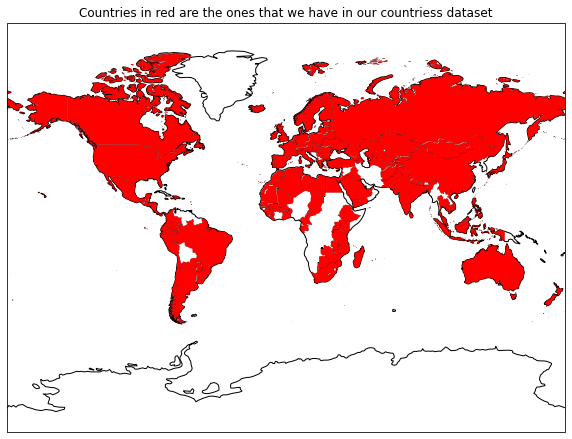

In [12]:
#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features.alpha3_name :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that we have in our countriess dataset")
plt.show()

## 1. Compute home position
Average the home position of the users. This is done like explained in the paper. The implementation is exactly the same as what was done for P2-milestone and so is not detailed and considered as an independent part (own libraries, constants, ...). The jupyter notebook that explain this can be found in the git under the name "replication_report".

In [13]:
#Librairies
from pyproj import Transformer #convert data from one type to another type

#Constants
SQUARE_SIZE = 25000

#Define the transformation from long-lat to x-y
trans = Transformer.from_crs(
    "epsg:4326", #long lat notation
    "epsg:3857", #pseudo mercator https://epsg.io/3857
    always_xy=True,
)

#Transform data long-lat -> x-y
bright_checkins["x"], bright_checkins["y"] = trans.transform(bright_checkins["longitude"].values, 
                                                             bright_checkins["latitude"].values)
gowalla_checkins["x"], gowalla_checkins["y"] = trans.transform(gowalla_checkins["longitude"].values, 
                                                             gowalla_checkins["latitude"].values)

#Some checkins at extreme values cannot be converted due to the projection -> remove them
bright_checkins = bright_checkins.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
gowalla_checkins = gowalla_checkins.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

#find square position to which the point belongs (take the divisor of the euclidian division) 
#(!i_x/i_y may be negative because the origin is at the center of Earth (Null Island))
bright_checkins["i_x"] = (bright_checkins["x"]/SQUARE_SIZE).astype(int)
bright_checkins["i_y"] = (bright_checkins["y"]/SQUARE_SIZE).astype(int)
gowalla_checkins["i_x"] = (gowalla_checkins["x"]/SQUARE_SIZE).astype(int)
gowalla_checkins["i_y"] = (gowalla_checkins["y"]/SQUARE_SIZE).astype(int)

#Now we can drop x, y, latitude and longitude
TO_REMOVE = ["latitude", "longitude","x"] #keep one column for the count
bright_checkins_light = bright_checkins.drop(columns=TO_REMOVE)
gowalla_checkins_light = gowalla_checkins.drop(columns=TO_REMOVE)
bright_checkins_light = bright_checkins_light.rename(columns={"y":"count"})
gowalla_checkins_light = gowalla_checkins_light.rename(columns={"y":"count"})

#For each user find the most used square

#Group by user and square position and count the nb of occurence
bright_checkins_zone_count = bright_checkins_light.groupby(["user","i_x","i_y"]).count().reset_index()
#create a dataframe with the max value
bright_checkins_zone_max = bright_checkins_zone_count.groupby(["user"]).max() \
                           .rename(columns={"count":"count_max"}).drop(columns=["i_x", "i_y"])
#merge both dataframes
bright_checkins_merge = pd.merge(bright_checkins_zone_max, bright_checkins_zone_count, left_on="user",right_on="user")
#keep only the lines where the count is equal to the maximum
bright_checkins_home = bright_checkins_merge[(bright_checkins_merge["count_max"] == bright_checkins_merge["count"])]
#There may be still some duplicates if tie (keep first)
bright_checkins_home = bright_checkins_home.drop_duplicates(subset=["user"],keep="first")
#by rehandling the dataframe we have for each user it's prefered square
bright_square_home = bright_checkins_home.drop(columns=["count_max","count"]).set_index("user")

#Group by user and square position and count the nb of occurence
gowalla_checkins_zone_count = gowalla_checkins_light.groupby(["user","i_x","i_y"]).count().reset_index()
#create a dataframe with the max value
gowalla_checkins_zone_max = gowalla_checkins_zone_count.groupby(["user"]).max() \
                           .rename(columns={"count":"count_max"}).drop(columns=["i_x", "i_y"])
#merge both dataframes
gowalla_checkins_merge = pd.merge(gowalla_checkins_zone_max, gowalla_checkins_zone_count, left_on="user",right_on="user")
#keep only the nb of checkins of the square is equal to the maximum
gowalla_checkins_home = gowalla_checkins_merge[(gowalla_checkins_merge["count_max"] == gowalla_checkins_merge["count"])]
#There may be still some duplicates if tie (keep first)
gowalla_checkins_home = gowalla_checkins_home.drop_duplicates(subset=["user"],keep="first")
#by rehandling the dataframe we have for each user it's prefered square
gowalla_square_home = gowalla_checkins_home.drop(columns=["count_max","count"]).set_index("user")

#For each row add the home square of the user
bright_checkins_full = pd.merge(bright_checkins, bright_square_home, left_on="user", 
                                right_index=True, how="outer", suffixes=('', '_h'))
gowalla_checkins_full = pd.merge(gowalla_checkins, gowalla_square_home, left_on="user", 
                                right_index=True, how="outer", suffixes=('', '_h'))

#Remove checkins not in home square
bright_home_checkins = bright_checkins_full[(bright_checkins_full["i_x"] == bright_checkins_full["i_x_h"]) 
                                            & (bright_checkins_full["i_y"] == bright_checkins_full["i_y_h"])]
gowalla_home_checkins = gowalla_checkins_full[(gowalla_checkins_full["i_x"] == gowalla_checkins_full["i_x_h"]) 
                                            & (gowalla_checkins_full["i_y"] == gowalla_checkins_full["i_y_h"])]

#Remove useless columns
TO_REMOVE = ["i_x", "i_y", "i_x_h", "i_y_h", "longitude", "latitude"]
bright_home_checkins_light = bright_home_checkins.drop(columns=TO_REMOVE)
gowalla_home_checkins_light = gowalla_home_checkins.drop(columns=TO_REMOVE)

#Mean the position for each user
bright_home_pos = bright_home_checkins_light.groupby(["user"]).mean()
gowalla_home_pos = gowalla_home_checkins_light.groupby(["user"]).mean()

#Define the transformation from x-y to long-lat (return to long lat for more precise distance mesure) (linear trans -> ok)
trans = Transformer.from_crs(
    "epsg:3857", #pseudo mercator https://epsg.io/3857
    "epsg:4326", #long lat notation
    always_xy=True,
)

#Transform data from x-y to long-lat
long, lat = trans.transform(bright_home_pos["x"].values, bright_home_pos["y"].values)
bright_home_pos["lat"] = lat
bright_home_pos["long"] = long
long, lat = trans.transform(gowalla_home_pos["x"].values, gowalla_home_pos["y"].values)
gowalla_home_pos["lat"] = lat
gowalla_home_pos["long"] = long

#Now we can drop x and y
TO_REMOVE = ["x", "y", "check-in time_x", "check-in time_y", "location id_x", "location id_y"]
bright_home_pos_light = bright_home_pos.drop(columns=TO_REMOVE)
gowalla_home_pos_light = gowalla_home_pos.drop(columns=TO_REMOVE)
gowalla_home_pos_light = gowalla_home_pos_light.drop(columns="location id")

In [14]:
#Sample dataframe to analyze and verify structure
#bright_home_pos_light.sample(4)
gowalla_home_pos_light.sample(4)

,lat,long
user,,
97293,59.336114,18.072717
132224,59.267935,18.350544
93480,59.862572,17.604123
10614,49.450972,11.055437


## 2. Compute nationality and remove non used countries

### 2.1 Compute nationality of the users
Convert longitude latitude to country. To do so we use the reverse_geocoder library.

In [15]:
#convert country name in alpha 2 name (one library return alpha2 from long lat, not country name)
def alpha2_to_country(alpha2_code):
    try:
        result = pycountry_convert.country_alpha2_to_country_name(alpha2_code)
    except Exception:
        result = np.nan
    return result

In [16]:
#Create new dataset
bright_home_complete = bright_home_pos_light
gowalla_home_complete = gowalla_home_pos_light

#Convert long-lat peer in tupple so it is easier for the library
bright_longlat_tupple = list(zip(bright_home_pos_light.lat, bright_home_pos_light.long))
gowalla_longlat_tupple = list(zip(gowalla_home_pos_light.lat, gowalla_home_pos_light.long))

#Search the localisation of each datapoint
bright_home_complete["loc"] = reverse_geocoder.search(bright_longlat_tupple)
gowalla_home_complete["loc"] = reverse_geocoder.search(gowalla_longlat_tupple)

#Separate the localisation information in the different part (name of the city, admin district, country code)
bright_home_complete = pd.DataFrame(bright_home_complete['loc'].tolist(), index=bright_home_complete.index)
gowalla_home_complete = pd.DataFrame(gowalla_home_complete['loc'].tolist(), index=gowalla_home_complete.index)

#Convert country code to country name
bright_home_complete['country'] = bright_home_complete.cc.apply(lambda cc: alpha2_to_country(cc))
gowalla_home_complete['country'] = gowalla_home_complete.cc.apply(lambda cc: alpha2_to_country(cc))

#Remove the useless columns
TO_REMOVE = ["name","admin1","admin2","cc"]
bright_home_complete = bright_home_complete.drop(columns = TO_REMOVE)
gowalla_home_complete = gowalla_home_complete.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
bright_home_complete.sample(4)
#gowalla_home_complete.sample(4)

Loading formatted geocoded file...


,lat,lon,country
user,,,
21565,39.23316,-76.63663,United States
6718,39.09973,-94.57857,United States
50215,40.72066,-73.72596,United States
38560,39.95233,-75.16379,United States


### 2.2 Find less used countries and remove them
To decide whatever we keep or not a country we compute its users density (sum of the two applications). The minimum density is set to 1 person over 1000, which seems to be a minimum to have a good representation fo the population. 

<span style="color:red">DISCUSS THIS CHOICE (upper quartile is also an idea) + ADD GRAPH OF DISTRIBUTION + ADD COMMENT ON HOW MANY ARE STILL HERE</span> 

In [17]:
#Parameter
MIN_DENSITY = 1e-5

#Count the users of each country
bright_countries_count = bright_home_complete.country.value_counts()
gowalla_countries_count = gowalla_home_complete.country.value_counts()

#Do a safety guard
countries_features_temp = countries_features

#Add the number of users to the countries features
countries_features_temp = countries_features_temp.merge(bright_countries_count, left_on = "country", right_index = True, how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"country_x":"country"})
countries_features_temp = countries_features_temp.rename(columns = {"country_y":"bright_count"})
countries_features_temp = countries_features_temp.merge(gowalla_countries_count, left_on = "country", right_index = True, how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"country_x":"country"})
countries_features_temp = countries_features_temp.rename(columns = {"country_y":"gowalla_count"})
#Replace the NaN values to 0
countries_features_temp = countries_features_temp.fillna(0)

#Sum the users of each application
countries_features_temp["users"] = countries_features_temp["bright_count"] + countries_features_temp["gowalla_count"]
#Compute the density of users in the population
countries_features_temp["density users"] = countries_features_temp["users"]/(countries_features_temp["Population in thousands (2017)"]*1000)

#keep only the countries that have a minimum density of users
countries_features_temp = countries_features_temp[countries_features_temp["density users"] > MIN_DENSITY]

#Sample dataframe to analyze and verify structure
countries_features_temp.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3_name,country,Region,Surface area (km2),Population in thousands (2017),...,"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI),Coastline (coast/area ratio),bright_count,gowalla_count,users,density users
22,6.2285,0.879714,0.744896,-0.065668,0.838239,CHL,Chile,SouthAmerica,756102,18055,...,85,99.7/93.3,100.0/90.9,0.02,-99,"0,85",228.0,104.0,332.0,0.000018
20,7.2321,0.927177,0.933913,0.124771,0.390843,CAN,Canada,NorthernAmerica,9984670,36624,...,324,100.0/99.0,100.0/99.0,-99,-99,"2,02",1417.0,2205.0,3622.0,0.000099
49,7.5045,0.974670,0.948892,0.246944,0.711710,ISL,Iceland,NorthernEurope,103000,335,...,952,100.0/100.0,98.7/100.0,-99,-99,"4,83",9.0,10.0,19.0,0.000057
53,7.0937,0.942082,0.886983,0.145785,0.357184,IRL,Ireland,NorthernEurope,69797,4762,...,114,97.9/97.8,89.1/92.9,-99,-99,"2,06",102.0,134.0,236.0,0.000050


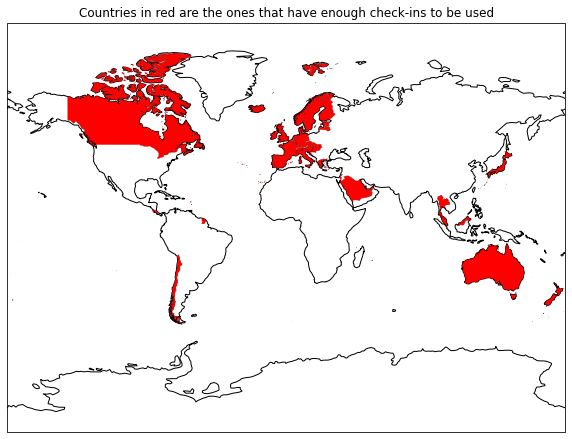

In [18]:
#Add Alpha 3 just for the plot
temp = countries_features_temp
temp['alpha3_name'] = countries_features_temp.country.apply(lambda name: do_fuzzy_search(name))

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features_temp.alpha3_name :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that have enough check-ins to be used")
plt.show()

In [19]:
print("There are "+str(countries_features_temp.shape[0])+" countries availible.")

There are 41 countries availible.


## 3. HAVE FUN GUYS